# Simple neural network


In this notebook, we are going to create and train a simple neural network on the digits dataset using pytorch.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

First, we need to load the data and make them into pytorch tensors.

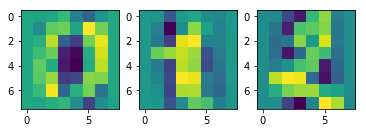

In [2]:
X, y = load_digits(return_X_y=True)

# Normalize

X -= X.mean(axis=0)
X /= np.std(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

f, axes = plt.subplots(1, 3)
for i, axe in enumerate(axes):
    axe.imshow(X[i].reshape(8, 8))

x = torch.tensor(X_train).float()
y = torch.tensor(y_train).long()
n, p = x.shape
x_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()

# Define the network

We will work with a simple network with two layers (one hidden layer).

The input $x$ is transformed into the output $z$ by the following operations:

$$y = \tanh(W_1x + b_1)$$
$$z = W_2y + b_2$$

**Exercise 1**: Define a function `net(x, W1, b1, W2, b2)` that implements this transform. Remember that `x` is a matrix of size $n\times p$

In [3]:
def net(x, W1, b1, W2, b2):
    y = x.mm(W1) + b1
    y = torch.tanh(y)
    z = y.mm(W2) + b2
    return z

Next, let us specify the parameters of the network, `W1, b1, W2, b2`. You can chose the size of the hidden layer, but the input and output sizes are determined by the problem.

**Exercise 2**: Define a set of parameters `W1, b1, W2, b2`, where you chose the size of the hidden layer. Make sure that all these parameters have their `requires_grad` flag set to true, so that we can compute the gradient with respect to them.

In order to check that eveything works, compute `net(x, W1, b1, W2, b2)`.

In [4]:
hidden_size = 20
input_size = 64
output_size = 10

W1 = torch.randn(input_size, hidden_size, requires_grad=True)
b1 = torch.randn(hidden_size, requires_grad=True)
W2 = torch.randn(hidden_size, output_size, requires_grad=True)
b2 = torch.randn(output_size, requires_grad=True)
output = net(x, W1, b1, W2, b2)

Next, we will define a cost function. We will use the classical cross entropy loss. It is imported from pytorch in the next cell.

In [5]:
from torch.nn.functional import cross_entropy

**Exercise 3**: Compute the current loss of the network, and then back-propagate to compute the gradient with respect to the parameters. Check the gradient with respect to W1.

In [6]:
loss = cross_entropy(output, y)
print(loss.item())
loss.backward()
print(W1.grad)

7.232069492340088
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0024, -0.0057, -0.0009,  ..., -0.0020,  0.0006,  0.0025],
        [-0.0165, -0.0383, -0.0030,  ..., -0.0151,  0.0094,  0.0178],
        ...,
        [ 0.0186,  0.0295, -0.0262,  ...,  0.0454, -0.0241, -0.0166],
        [ 0.0064,  0.0192, -0.0248,  ...,  0.0027, -0.0168,  0.0091],
        [ 0.0021,  0.0032, -0.0005,  ..., -0.0016, -0.0009,  0.0075]])


We are almost ready to train our network!

But first, we will need to compute the accuracy of the network, on the train and test set.

**Exercise 4**: Define a function `accuracy(X, y, W1, b1, W2, b2)` that computes the accuracy of the network on the dataset `x`with true labels `y`. Remember that the predicted class at the output of the network is computed as the argmaximum of the output. Compute the current accuracy of the network on the train set. Is it normal ?

In [7]:
def accuracy(X, y, W1, b1, W2, b2):
    output = net(X, W1, b1, W2, b2)
    pred = output.argmax(axis=1)
    return (pred == y).sum().item() / len(y)


accuracy(x, y, W1, b1, W2, b2)

0.10393466963622866

# Training the network

We are now ready to train the network, using back-propagation and stochastic gradient descent.
First, we define the number of iterations of the algorithm, the step size, and the batch size. We also reinitialize the weights. Finally, we will store the train and test accuracy during the training.

In [8]:
n_iter = 1000
step_size = 0.1
batch_size = 64


W1 = torch.randn(input_size, hidden_size, requires_grad=True)
b1 = torch.randn(hidden_size, requires_grad=True)
W2 = torch.randn(hidden_size, output_size, requires_grad=True)
b2 = torch.randn(output_size, requires_grad=True)

test_list = []
train_list = []

**Exercise 5**: Complete the following training list, so that each parameter is updated at each iteration.

Remember that at each iteration, you should:
* compute the output of the network with respect to the batch
* Compute the loss, and backpropagate
* Update each parameter with gradient descent
* Refresh the gradient of each parameter. To do so, you can do:

```
W1 = W1.detach()
W1.requires_grad=True
```

In [9]:
for i in range(n_iter):
    batch_idx = torch.argsort(torch.randn(n))[:batch_size]
    x_batch = x[batch_idx]
    y_batch = y[batch_idx]
    output = net(x_batch, W1, b1, W2, b2)
    loss = cross_entropy(output, y_batch)
    loss.backward()
    with torch.no_grad():
        W1 = W1 - step_size * W1.grad
        W1 = W1.detach()
        W1.requires_grad = True
        b1 = b1 - step_size * b1.grad
        b1 = b1.detach()
        b1.requires_grad = True
        W2 = W2 - step_size * W2.grad
        W2 = W2.detach()
        W2.requires_grad = True
        b2 = b2 - step_size * b2.grad
        b2 = b2.detach()
        b2.requires_grad = True
    if i % 10 == 0:
        with torch.no_grad():
            train_acc = accuracy(x, y, W1, b1, W2, b2)
            test_acc = accuracy(x_test, y_test, W1, b1, W2, b2)
        test_list.append(test_acc)
        train_list.append(train_acc)
        print('Iteration {} Train loss: {:1.3f} Train acc: {:1.3f} Test acc {:1.3f}'.format(i, loss.item(), train_acc, test_acc))

Iteration 0 Train loss: 7.466 Train acc: 0.061 Test acc 0.084
Iteration 10 Train loss: 6.943 Train acc: 0.103 Test acc 0.138
Iteration 20 Train loss: 4.972 Train acc: 0.159 Test acc 0.209
Iteration 30 Train loss: 4.123 Train acc: 0.258 Test acc 0.291
Iteration 40 Train loss: 3.044 Train acc: 0.344 Test acc 0.356
Iteration 50 Train loss: 2.067 Train acc: 0.425 Test acc 0.436
Iteration 60 Train loss: 2.006 Train acc: 0.509 Test acc 0.498
Iteration 70 Train loss: 1.492 Train acc: 0.549 Test acc 0.553
Iteration 80 Train loss: 1.596 Train acc: 0.590 Test acc 0.578
Iteration 90 Train loss: 1.040 Train acc: 0.615 Test acc 0.620
Iteration 100 Train loss: 1.625 Train acc: 0.642 Test acc 0.638
Iteration 110 Train loss: 1.150 Train acc: 0.656 Test acc 0.647
Iteration 120 Train loss: 0.956 Train acc: 0.676 Test acc 0.667
Iteration 130 Train loss: 0.923 Train acc: 0.703 Test acc 0.691
Iteration 140 Train loss: 1.431 Train acc: 0.722 Test acc 0.716
Iteration 150 Train loss: 1.006 Train acc: 0.736 Te

**Exercise 6**: Display the learning curves. You can then play with the network and training parameters:
what happens when you change the learning rate, the number of hidden sizes, etc?

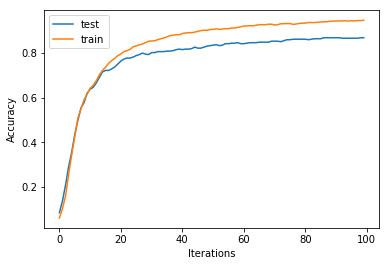

In [10]:
plt.plot(test_list, label='test')
plt.plot(train_list, label='train')

plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()